2. Verbindung zur Datenbank / 连接 Chinook 数据库

In [9]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

engine = create_engine("sqlite:///../data/Chinook.sqlite")
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", engine)


,name
0,Album
1,Artist
2,Customer
3,Employee
4,Genre
5,Invoice
6,InvoiceLine
7,MediaType
8,Playlist
9,PlaylistTrack


3. Umsatz-Analyse / 销售额分析

3.1 Gesamtumsatz & mittlerer Einkaufswert

总销售额 & 平均订单金额

In [10]:
invoices = pd.read_sql('SELECT * FROM "Invoice";', engine)
# 或者
# invoices = pd.read_sql("SELECT * FROM Invoice;", engine)

gesamtumsatz = invoices["Total"].sum()
mittlerer_wert = invoices["Total"].mean()

print("Gesamtumsatz:", gesamtumsatz)
print("Mittlerer Einkaufswert:", mittlerer_wert)


Gesamtumsatz: 2328.5999999999995
Mittlerer Einkaufswert: 5.651941747572814


3.2 Umsatz pro Monat / 各月份销售额

  YearMonth  Total
0   2021-01  35.64
1   2021-02  37.62
2   2021-03  37.62
3   2021-04  37.62
4   2021-05  37.62


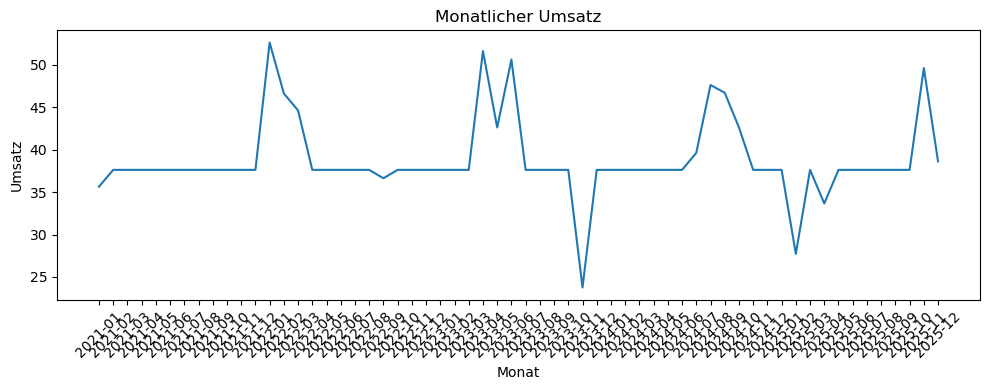

In [11]:
# InvoiceDate 转为 datetime
invoices["InvoiceDate"] = pd.to_datetime(invoices["InvoiceDate"])

invoices["YearMonth"] = invoices["InvoiceDate"].dt.to_period("M").astype(str)

umsatz_monat = (
    invoices
    .groupby("YearMonth")["Total"]
    .sum()
    .reset_index()
    .sort_values("YearMonth")
)

print(umsatz_monat.head())

# 可视化：按月份的总销售额
plt.figure(figsize=(10, 4))
plt.plot(umsatz_monat["YearMonth"], umsatz_monat["Total"])
plt.xticks(rotation=45)
plt.xlabel("Monat")
plt.ylabel("Umsatz")
plt.title("Monatlicher Umsatz")
plt.tight_layout()
plt.show()


4. Kundenverhalten / 客户行为

4.1 Top-Kunden（按总销售额）

    CustomerId FirstName    LastName  Total
5            6    Helena        Holý  49.62
25          26   Richard  Cunningham  47.62
56          57      Luis       Rojas  46.62
45          46      Hugh    O'Reilly  45.62
44          45  Ladislav      Kovács  45.62
36          37      Fynn  Zimmermann  43.62
27          28     Julia     Barnett  43.62
23          24     Frank     Ralston  43.62
6            7    Astrid      Gruber  42.62
24          25    Victor     Stevens  42.62


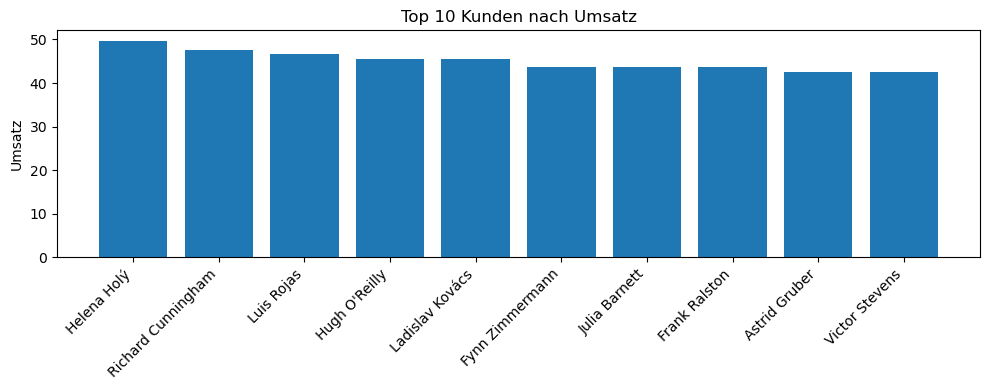

In [15]:
# invoices 里 CustomerId -> customers 表
customers = pd.read_sql('SELECT * FROM "Customer";', engine)

umsatz_kunde = (
    invoices
    .groupby("CustomerId")["Total"]
    .sum()
    .reset_index()
    .merge(customers, on="CustomerId", how="left")
)

top_kunden = umsatz_kunde.sort_values("Total", ascending=False).head(10)
print(top_kunden[["CustomerId", "FirstName", "LastName", "Total"]])

# 条形图
plt.figure(figsize=(10, 4))
plt.bar(
    top_kunden["FirstName"] + " " + top_kunden["LastName"],
    top_kunden["Total"]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Umsatz")
plt.title("Top 10 Kunden nach Umsatz")
plt.tight_layout()
plt.show()


4.2 Top 3 Regionen / 销售额最高的 3 个地区

   BillingCountry   Total
22            USA  523.06
5          Canada  303.96
10         France  195.10


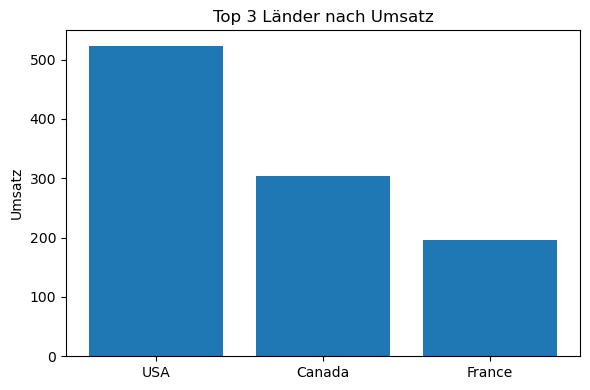

In [16]:
umsatz_land = (
    invoices
    .groupby("BillingCountry")["Total"]
    .sum()
    .reset_index()
    .sort_values("Total", ascending=False)
)

top_3_laender = umsatz_land.head(3)
print(top_3_laender)

plt.figure(figsize=(6, 4))
plt.bar(top_3_laender["BillingCountry"], top_3_laender["Total"])
plt.ylabel("Umsatz")
plt.title("Top 3 Länder nach Umsatz")
plt.tight_layout()
plt.show()


5. Artists & Genre Performance / 艺术家与流派表现

用到的表：

invoice_items（数量 Quantity、每条 trackId）

tracks（TrackId, AlbumId, GenreId）

genres（GenreId, Name）

albums（AlbumId, Title, ArtistId）

artists（ArtistId, Name）

Top Genres:
             GenreName  Quantity
17                Rock       835
12               Latin       386
13               Metal       264
1   Alternative & Punk       244
11                Jazz        80


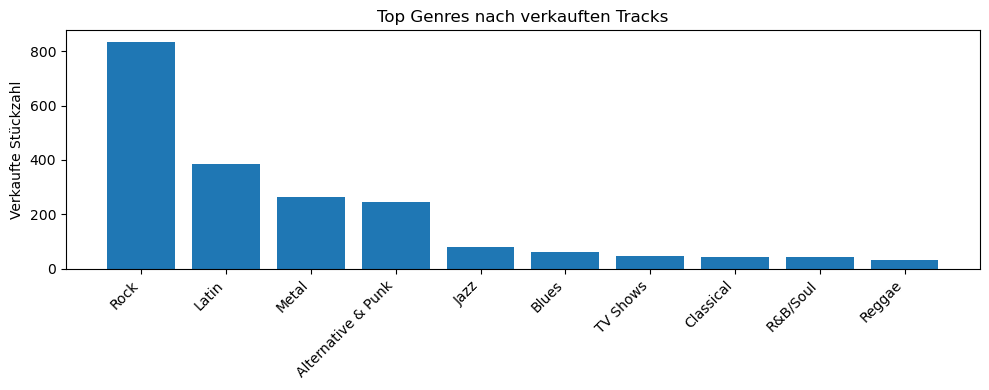

In [31]:
# 5. Artists und Genres Performance / 艺术家与流派表现
# 5.1 Meistverkauftes Genre / 最畅销流派
# 只选需要的列，并在 SQL 里直接起别名，避免 Name_x / Name_y

invoice_items = pd.read_sql('SELECT InvoiceLineId, TrackId, Quantity FROM "InvoiceLine";', engine)

tracks = pd.read_sql('SELECT TrackId, GenreId FROM "Track";', engine)

genres = pd.read_sql('SELECT GenreId, Name AS GenreName FROM "Genre";', engine)

# 连接：InvoiceLine -> Track -> Genre
genre_sales = (
    invoice_items
    .merge(tracks, on="TrackId")
    .merge(genres, on="GenreId")
)

# 现在列名里只有一个 GenreName，可以直接 groupby
genre_agg = (
    genre_sales
    .groupby("GenreName")["Quantity"]
    .sum()
    .reset_index()
    .sort_values("Quantity", ascending=False)
)

print("Top Genres:")
print(genre_agg.head())

plt.figure(figsize=(10, 4))
plt.bar(genre_agg["GenreName"].head(10), genre_agg["Quantity"].head(10))
plt.xticks(rotation=45, ha="right")
plt.ylabel("Verkaufte Stückzahl")
plt.title("Top Genres nach verkauften Tracks")
plt.tight_layout()
plt.show()


Top Artists:
                  ArtistName  Quantity
69               Iron Maiden       140
156                       U2       107
95                 Metallica        91
82              Led Zeppelin        87
109  Os Paralamas Do Sucesso        45
37               Deep Purple        44
51             Faith No More        42
85                      Lost        41
49              Eric Clapton        40
120                   R.E.M.        39


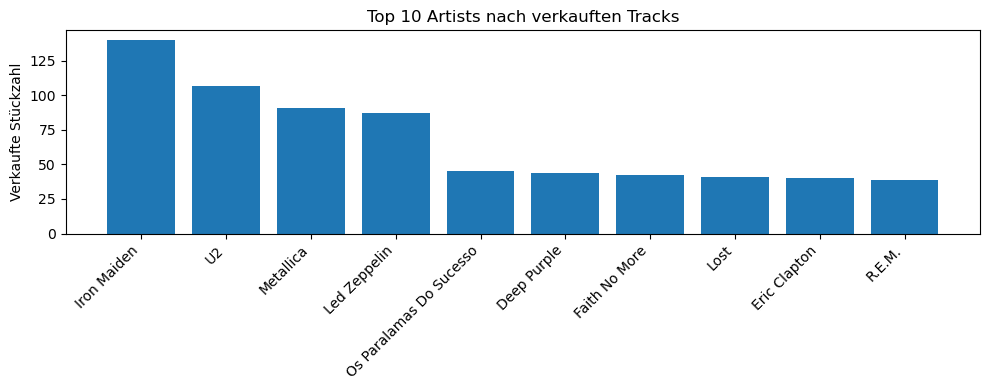

In [34]:
# 5.2 Band mit den meisten verkauften Tracks / 销量最高的乐队

# 这里重新读取一次 Track，并且这次专门只拿 TrackId 和 AlbumId
tracks_album = pd.read_sql(
    'SELECT TrackId, AlbumId FROM "Track";',
    engine
)

albums = pd.read_sql(
    'SELECT AlbumId, Title AS AlbumTitle, ArtistId FROM "Album";',
    engine
)

artists = pd.read_sql(
    'SELECT ArtistId, Name AS ArtistName FROM "Artist";',
    engine
)

artist_sales = (
    invoice_items                           # 来自 5.1，已经有 TrackId、Quantity
    .merge(tracks_album, on="TrackId", how="left")  # 这里只用 tracks_album，不用前面的 tracks
    .merge(albums, on="AlbumId", how="left")
    .merge(artists, on="ArtistId", how="left")
)

artist_agg = (
    artist_sales
    .groupby("ArtistName")["Quantity"]
    .sum()
    .reset_index()
    .sort_values("Quantity", ascending=False)
)

print("Top Artists:")
print(artist_agg.head(10))

plt.figure(figsize=(10, 4))
plt.bar(artist_agg["ArtistName"].head(10), artist_agg["Quantity"].head(10))
plt.xticks(rotation=45, ha="right")
plt.ylabel("Verkaufte Stückzahl")
plt.title("Top 10 Artists nach verkauften Tracks")
plt.tight_layout()
plt.show()

Top Alben:
                                   AlbumTitle  Quantity
169                            Minha Historia        27
105                             Greatest Hits        26
282                                 Unplugged        25
9                                    Acústico        22
108                             Greatest Kiss        20
202                              Prenda Minha        19
69                          Chronicle, Vol. 2        19
176  My Generation - The Very Best Of The Who        19
68                          Chronicle, Vol. 1        18
41   Battlestar Galactica (Classic), Season 1        18


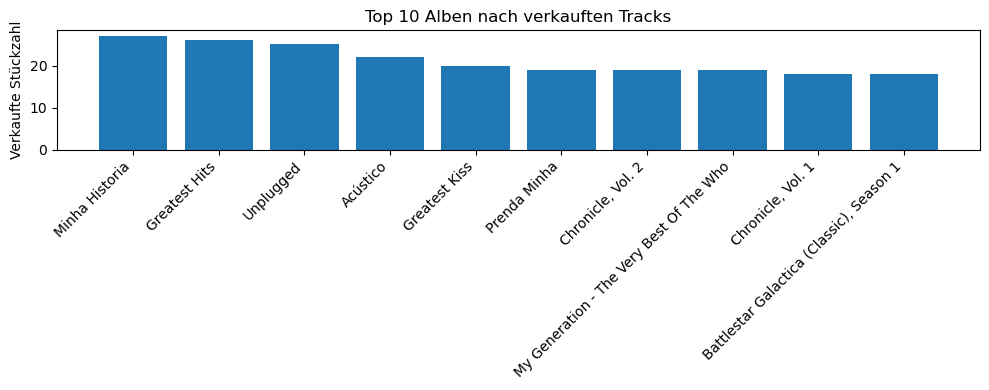

In [35]:
# 5.3 Album mit den meisten Verkäufen / 最畅销专辑
# ---------------------------------------------

album_agg = (
    artist_sales
    .groupby("AlbumTitle")["Quantity"]
    .sum()
    .reset_index()
    .sort_values("Quantity", ascending=False)
)

print("Top Alben:")
print(album_agg.head(10))

plt.figure(figsize=(10, 4))
plt.bar(album_agg["AlbumTitle"].head(10), album_agg["Quantity"].head(10))
plt.xticks(rotation=45, ha="right")
plt.ylabel("Verkaufte Stückzahl")
plt.title("Top 10 Alben nach verkauften Tracks")
plt.tight_layout()
plt.show()

Sales Performance (nach Umsatz):
  FirstName LastName   Total
0      Jane  Peacock  833.04
1  Margaret     Park  775.40
2     Steve  Johnson  720.16


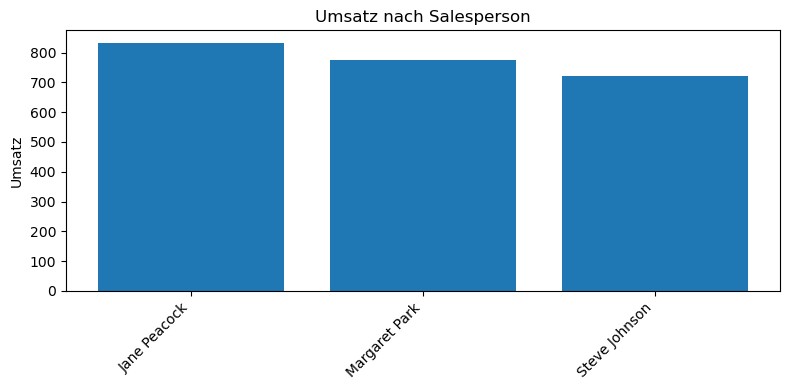

In [37]:
# 6. Sales Performance / 销售员表现
# ================================

# 1) 发票表（Invoice）：我们假设之前已经读过，如果没有，可以补上这一行：
invoices = pd.read_sql('SELECT * FROM "Invoice";', engine)

# 2) 客户表（Customer）：这里面才有 SupportRepId
customers = pd.read_sql(
    'SELECT CustomerId, SupportRepId FROM "Customer";',
    engine
)

# 3) 员工表（Employee）：销售员姓名在这里
employees = pd.read_sql(
    'SELECT EmployeeId, FirstName, LastName FROM "Employee";',
    engine
)

# 4) 先把 invoices 和 customers 连接上，拿到每张发票对应的 SupportRepId
invoice_with_rep = (
    invoices
    .merge(customers, on="CustomerId", how="left")
)

# 5) 现在才可以按 SupportRepId 聚合总销售额 Total
sales_by_rep = (
    invoice_with_rep
    .groupby("SupportRepId")["Total"]
    .sum()
    .reset_index()
    .merge(
        employees,
        left_on="SupportRepId",
        right_on="EmployeeId",
        how="left"
    )
)

# 6) 排序 + 查看结果
sales_by_rep = sales_by_rep.sort_values("Total", ascending=False)

print("Sales Performance (nach Umsatz):")
print(sales_by_rep[["FirstName", "LastName", "Total"]])

# 7) 可视化
plt.figure(figsize=(8, 4))
plt.bar(
    sales_by_rep["FirstName"] + " " + sales_by_rep["LastName"],
    sales_by_rep["Total"]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Umsatz")
plt.title("Umsatz nach Salesperson")
plt.tight_layout()
plt.show()
